## Import Libraries

In [1]:
import openrouteservice as ors
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import folium
import matplotlib.pyplot as plt
from folium.plugins import BeautifyIcon

import copy
from pprint import pprint 

In [2]:
import constants
import fleet_manager as fm
import utils


## Set Configurations

In [3]:
pd.options.display.max_rows = 1000    # Show up to 1000 rows
pd.options.display.max_columns = 50   # Show up to 50 columns
pd.set_option('display.max_colwidth', None) # Show all contents in the cells

In [4]:
# change the decimal precision --> default = 6 digits
gpd.options.display_precision = 16 

## Client to make ORS API calls

In [5]:
client = ors.Client(constants.API_KEY)
client

## User Input

1. postcode
2. bot_count in the fleet
3. customised (heterogenous) fleet? (always `False` for now)

In [6]:
postcode = 'LS9 0BT'

# only options: 1, 2, 3
bot_count = 3

customise = False

## Search and Locate given postcode on the Map

In [7]:
# find the postcode coordinates
station = client.pelias_search(text=postcode)
pprint(station)

{'bbox': [-1.517644, 53.789386, -1.517644, 53.789386],
 'features': [{'bbox': [-1.517644, 53.789386, -1.517644, 53.789386],
               'geometry': {'coordinates': [-1.517644, 53.789386],
                            'type': 'Point'},
               'properties': {'accuracy': 'centroid',
                              'addendum': {'concordances': {'gp:id': '27526862'}},
                              'confidence': 1,
                              'continent': 'Europe',
                              'continent_gid': 'whosonfirst:continent:102191581',
                              'country': 'United Kingdom',
                              'country_a': 'GBR',
                              'country_gid': 'whosonfirst:country:85633159',
                              'county': 'Leeds',
                              'county_gid': 'whosonfirst:county:1360698749',
                              'gid': 'whosonfirst:postalcode:470842435',
                              'id': '470842435',
          

### Extract postcode location coordinates

In [8]:
station_coords = station['features'][0]['geometry']['coordinates']
station_coords

[-1.517644, 53.789386]

### Locate on Folium Map, mark it as starting point

In [9]:
m = folium.Map(location=list(reversed(station_coords)), tiles="cartodbpositron", zoom_start=17)

# Create icon using folium.Icon for station from where all bots start and end
icon=BeautifyIcon(
        icon_shape='marker',
        text_color='black',
        background_color="#FFF",
        inner_icon_style="font-size:12px;padding-top:-5px;",
        icon='flag-checkered'
    )

# Add marker with the created icon to the map
folium.Marker(location=list(reversed(station_coords)), icon=icon).add_to(m)

# Display the map
m

## Create a Fleet using FleetManager class.

args:
1. bot_count = number of bots in the fleet
2. start = starting (and ending) point for all bots

In [10]:
fleet = fm.FleetManager(bot_count=bot_count, start=list(reversed(station_coords)))
fleet

## Get Potholes Dataset

### Read using GeoPandas library

In [11]:
potholes_details = gpd.read_file(constants.POTHOLES_DATA_FILEPATH)
potholes_details

,defect,dim,geometry
0,pothole,1x0.5x0.2,POINT (-1.5202653014356144 53.7886094292194912)
1,pothole,0.5x1.2x0.2,POINT (-1.5185276122489597 53.7884573448203867)
2,pothole,0.5x1.2x0.2,POINT (-1.5181200061435902 53.7886537870654990)
3,pothole,1x0.5x0.2,POINT (-1.5165367499993749 53.7894171973833295)
4,pothole,1x0.5x0.2,POINT (-1.5158937220954840 53.7902010524229013)
5,pothole,2x0.5x0.2,POINT (-1.5157207769570675 53.7901240147059525)
6,pothole,1x0.5x0.2,POINT (-1.5150777490531766 53.7897200289646946)
7,pothole,1x0.5x0.2,POINT (-1.5165475271180355 53.7900878370366797)
8,pothole,1x0.5x0.1,POINT (-1.5178539965092739 53.7884356902426077)


In [12]:
# Split the "dim" column and convert to numeric (float) values
def split_dimensions(x):
    l, w, d = map(float, x.split('x'))
    return l, w, d

# Apply the split function
l, w, d = zip(*potholes_details['dim'].apply(split_dimensions))

# Create new columns with the extracted numeric data
potholes_details['l'] = l
potholes_details['w'] = w
potholes_details['d'] = d

potholes_details

,defect,dim,geometry,l,w,d
0,pothole,1x0.5x0.2,POINT (-1.5202653014356144 53.7886094292194912),1.0,0.5,0.2
1,pothole,0.5x1.2x0.2,POINT (-1.5185276122489597 53.7884573448203867),0.5,1.2,0.2
2,pothole,0.5x1.2x0.2,POINT (-1.5181200061435902 53.7886537870654990),0.5,1.2,0.2
3,pothole,1x0.5x0.2,POINT (-1.5165367499993749 53.7894171973833295),1.0,0.5,0.2
4,pothole,1x0.5x0.2,POINT (-1.5158937220954840 53.7902010524229013),1.0,0.5,0.2
5,pothole,2x0.5x0.2,POINT (-1.5157207769570675 53.7901240147059525),2.0,0.5,0.2
6,pothole,1x0.5x0.2,POINT (-1.5150777490531766 53.7897200289646946),1.0,0.5,0.2
7,pothole,1x0.5x0.2,POINT (-1.5165475271180355 53.7900878370366797),1.0,0.5,0.2
8,pothole,1x0.5x0.1,POINT (-1.5178539965092739 53.7884356902426077),1.0,0.5,0.1


In [13]:
potholes_details.duplicated()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

In [14]:
potholes_details.isnull().sum()

defect      0
dim         0
geometry    0
l           0
w           0
d           0
dtype: int64

In [15]:
potholes_details.describe()

,l,w,d
count,9.000000,9.000000,9.000000
mean,1.000000,0.655556,0.188889
std,0.433013,0.308671,0.033333
min,0.500000,0.500000,0.100000
25%,1.000000,0.500000,0.200000
50%,1.000000,0.500000,0.200000
75%,1.000000,0.500000,0.200000
max,2.000000,1.200000,0.200000


In [16]:
potholes_details[['defect']].value_counts()

defect 
pothole    9
dtype: int64

In [17]:
potholes_details[['dim']].value_counts()

dim        
1x0.5x0.2      5
0.5x1.2x0.2    2
1x0.5x0.1      1
2x0.5x0.2      1
dtype: int64

### Read using Pandas library

In [18]:
potholes_data = pd.read_json(constants.POTHOLES_DATA_FILEPATH)
potholes_data

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.2'}, 'geometry': {'coordinates': [-1.520265301435614, 53.78860942921949], 'type': 'Point'}, 'id': 0}"
1,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '0.5x1.2x0.2'}, 'geometry': {'coordinates': [-1.518527612248959, 53.78845734482039], 'type': 'Point'}, 'id': 1}"
2,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '0.5x1.2x0.2'}, 'geometry': {'coordinates': [-1.51812000614359, 53.7886537870655], 'type': 'Point'}, 'id': 2}"
3,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.2'}, 'geometry': {'coordinates': [-1.516536749999375, 53.78941719738333], 'type': 'Point'}, 'id': 3}"
4,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.2'}, 'geometry': {'coordinates': [-1.515893722095484, 53.7902010524229], 'type': 'Point'}, 'id': 4}"
5,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '2x0.5x0.2'}, 'geometry': {'coordinates': [-1.515720776957067, 53.79012401470595], 'type': 'Point'}, 'id': 5}"
6,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.2'}, 'geometry': {'coordinates': [-1.515077749053176, 53.789720028964695], 'type': 'Point'}, 'id': 6}"
7,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.2'}, 'geometry': {'coordinates': [-1.516547527118035, 53.79008783703668], 'type': 'Point'}, 'id': 7}"
8,FeatureCollection,"{'type': 'Feature', 'properties': {'defect': 'pothole', 'dim': '1x0.5x0.1'}, 'geometry': {'coordinates': [-1.517853996509273, 53.78843569024261], 'type': 'Point'}, 'id': 8}"


## Calculate estimates (using Utility Functions)

In [20]:
ut = utils.Utils()
ut

### Calculate estimates and store in a dataframe

In [21]:
# Function to get pothole estimates
def get_pothole_details(feature):
    volume, surface_area, qty_reqd, setup_time, service_time = ut.calculate_eta(feature)
    return {'id': feature['id'],
            'defect': feature['properties']['defect'],
            'volume': round(volume, 6),
            'surface_area': round(surface_area, 6),
            'qty_reqd': round(qty_reqd, 2),
            'setup_time': round(setup_time, 2),
            'service_time': round(service_time, 2)}

## Create Jobs based on Pothole Estimates

### Create Jobs

#### Break large jobs into smaller jobs

In [22]:
# Function to get job details for a pothole feature
def create_job(feature):
    volume, surface_area, qty_reqd, setup_time, service_time = ut.calculate_eta(feature)
    job_list = []
    cntr = 1
    while qty_reqd > fleet.bot_capacity:
        job_list.append(
            ors.optimization.Job(location=feature['geometry']['coordinates'],
                                    id=feature['id']*100 + cntr,
                                    # setup=setup_time,
                                    service=service_time,
                                    amount=[fleet.bot_capacity]
                                )
        )
        cntr += 1
        qty_reqd -= fleet.bot_capacity
    job_list.append(
        ors.optimization.Job(location=feature['geometry']['coordinates'],
                             id=feature['id']*100,
                             # setup=setup_time,
                             service=service_time,
                             amount=[math.ceil(qty_reqd)]
                            )
    )
    return job_list

In [23]:
# Iterate through pothole data to calculate estimates and store job details

pothole_estimates = []
jobs = []

for feature in potholes_data['features']:
    pothole_estimates.append(get_pothole_details(feature))
    jobs.extend(create_job(feature))

#### Potholes estimates

In [24]:
pedf = pd.DataFrame(pothole_estimates)
pedf

,id,defect,volume,surface_area,qty_reqd,setup_time,service_time
0,0,pothole,0.10,0.5,240.0,300,330.0
1,1,pothole,0.12,0.6,288.0,300,396.0
2,2,pothole,0.12,0.6,288.0,300,396.0
3,3,pothole,0.10,0.5,240.0,300,330.0
4,4,pothole,0.10,0.5,240.0,300,330.0
5,5,pothole,0.20,1.0,480.0,300,660.0
6,6,pothole,0.10,0.5,240.0,300,330.0
7,7,pothole,0.10,0.5,240.0,300,330.0
8,8,pothole,0.05,0.5,120.0,300,315.0


#### Jobs List

In [25]:
for j in jobs:
    print(j, j.id)

<openrouteservice.optimization.Job object at 0x164289d10> 0
<openrouteservice.optimization.Job object at 0x16429ef90> 100
<openrouteservice.optimization.Job object at 0x16429e190> 200
<openrouteservice.optimization.Job object at 0x16429f2d0> 300
<openrouteservice.optimization.Job object at 0x16429e290> 400
<openrouteservice.optimization.Job object at 0x16429f290> 500
<openrouteservice.optimization.Job object at 0x16429f250> 600
<openrouteservice.optimization.Job object at 0x16429f310> 700
<openrouteservice.optimization.Job object at 0x16429f1d0> 800


## Plot Potholes on Map

In [26]:
# plot potholes(jobs) and routes

for pothole in potholes_data['features']:
    folium.Marker(
        location=list(reversed(pothole['geometry']['coordinates'])),
        tooltip=folium.map.Tooltip(
            """<table>
            <tr><td>ID: <td>{}
            <tr><td>Defect: <td>{}
            <tr><td>Volume: <b><td>{} m<sup>3</sup>
            <tr><td>Surface Area: <b><td>{} m<sup>2</sup>
            <tr><td>Material Required: <b><td>{} kg
            """.format(
                pothole['id'],
                pothole['properties']['defect'],
                pedf[pedf['id']==pothole['id']]['volume'].values[0],
                pedf[pedf['id']==pothole['id']]['surface_area'].values[0],
                pedf[pedf['id']==pothole['id']]['qty_reqd'].values[0]
                )
            , opacity=1),
        icon=BeautifyIcon(
            # icon_shape='marker',
            # number=pothole['id'],
            text_color='white',
            background_color="red",
            inner_icon_style="font-size:12px;padding-top:-5px;",
            icon='info'
        )
        # add details in tooltip
        # add routes
        # add layer control
    ).add_to(m)

m

#### Issue: Unassigned Jobs
If total demand for material required is more than that can be solved in 1 trip per bot, there will be unassigned jobs list in the API response.
#### Fix: Plan Multiple Trips for the bots
Keep planning multiple trips for the bots until all jobs are fulfilled.

## Plan the Routes

In [27]:
def plan_the_routes(pending_jobs=jobs, available_bots=fleet.bots, start_time=0):
    offset_time = 0
    route_plans = []

    # Optimize the initial route plan
    route_plans.append(ors.optimization.optimization(
                        client,
                        jobs=pending_jobs,
                        vehicles=available_bots,
                        geometry=True
                    )
                )

    # add start time in case of replanning after fault tolerance
    for route in route_plans[-1]['routes']:
        for step in route['steps']:
            step['arrival'] += offset_time + start_time

    # Loop until all jobs are assigned
    while route_plans[-1]['unassigned']:
        
        for route in route_plans[-1]['routes']:
            for step in route['steps']:
                offset_time = max(offset_time, step['arrival'])

        # Get unassigned job IDs
        unassigned_job_ids = [job['id'] for job in route_plans[-1]['unassigned']]
        unassigned_jobs_list = [job for job in jobs if job.id in unassigned_job_ids]
        # print('Unassigned jobs:', unassigned_job_ids)

        # get new route plan for remaining jobs
        route_plans.append(ors.optimization.optimization(
                                client,
                                jobs=unassigned_jobs_list,
                                vehicles=fleet.bots,
                                geometry=True
                            )
                        )

        max_dist = 0
        for rou in route_plans[-2]['routes']:
            max_dist = max(max_dist, rou['distance'])

        for route in route_plans[-1]['routes']:
            for step in route['steps']:
                step['arrival'] += offset_time + start_time
                
                step['distance'] += max_dist

    return route_plans

In [28]:
route_plans = plan_the_routes()
route_plans

[{'code': 0,
  'summary': {'cost': 452,
   'routes': 3,
   'unassigned': 0,
   'delivery': [2376],
   'amount': [2376],
   'pickup': [0],
   'setup': 0,
   'service': 3417,
   'duration': 452,
   'waiting_time': 0,
   'priority': 0,
   'distance': 2432,
   'violations': [],
   'computing_times': {'loading': 70, 'solving': 3, 'routing': 50}},
  'unassigned': [],
  'routes': [{'vehicle': 0,
    'cost': 133,
    'delivery': [960],
    'amount': [960],
    'pickup': [0],
    'setup': 0,
    'service': 1320,
    'duration': 133,
    'waiting_time': 0,
    'priority': 0,
    'distance': 716,
    'steps': [{'type': 'start',
      'location': [-1.517644, 53.789386],
      'setup': 0,
      'service': 0,
      'waiting_time': 0,
      'load': [960],
      'arrival': 0,
      'duration': 0,
      'violations': [],
      'distance': 0},
     {'type': 'job',
      'location': [-1.515077749053176, 53.789720028964695],
      'id': 600,
      'setup': 0,
      'service': 330,
      'waiting_time': 0,

## Visualise Routes on Map

In [29]:
line_colours = [['orange', 'blue', 'green'],
                ['black', 'yellow', 'red'],
                ['purple', 'brown', 'teal'],
                ['cyan', 'magenta', 'lime']]

for i, route_plan in enumerate(route_plans):
    for route in route_plan['routes']:
        folium.PolyLine(locations=[list(reversed(coords)) for coords in 
                                   ors.convert.decode_polyline(route['geometry'])['coordinates']], \
                                   weight=4, color=line_colours[i][route['vehicle']], opacity=0.5) \
        .add_to(m)

m

## Convert JSON to DF, and Visualise charts

In [30]:
pd.DataFrame([route['steps'] for route in route_plan['routes']])

,0,1,2,3,4
0,"{'type': 'start', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [960], 'arrival': 0, 'duration': 0, 'violations': [], 'distance': 0}","{'type': 'job', 'location': [-1.515077749053176, 53.789720028964695], 'id': 600, 'setup': 0, 'service': 330, 'waiting_time': 0, 'job': 600, 'load': [720], 'arrival': 48, 'duration': 48, 'violations': [], 'distance': 281}","{'type': 'job', 'location': [-1.515893722095484, 53.7902010524229], 'id': 400, 'setup': 0, 'service': 330, 'waiting_time': 0, 'job': 400, 'load': [480], 'arrival': 396, 'duration': 66, 'violations': [], 'distance': 358}","{'type': 'job', 'location': [-1.515720776957067, 53.79012401470595], 'id': 500, 'setup': 0, 'service': 660, 'waiting_time': 0, 'job': 500, 'load': [0], 'arrival': 730, 'duration': 70, 'violations': [], 'distance': 373}","{'type': 'end', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [0], 'arrival': 1453, 'duration': 133, 'violations': [], 'distance': 716}"
1,"{'type': 'start', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [720], 'arrival': 0, 'duration': 0, 'violations': [], 'distance': 0}","{'type': 'job', 'location': [-1.520265301435614, 53.78860942921949], 'id': 0, 'setup': 0, 'service': 330, 'waiting_time': 0, 'job': 0, 'load': [480], 'arrival': 74, 'duration': 74, 'violations': [], 'distance': 430}","{'type': 'job', 'location': [-1.516547527118035, 53.79008783703668], 'id': 700, 'setup': 0, 'service': 330, 'waiting_time': 0, 'job': 700, 'load': [240], 'arrival': 498, 'duration': 168, 'violations': [], 'distance': 989}","{'type': 'job', 'location': [-1.516536749999375, 53.78941719738333], 'id': 300, 'setup': 0, 'service': 330, 'waiting_time': 0, 'job': 300, 'load': [0], 'arrival': 853, 'duration': 193, 'violations': [], 'distance': 1094}","{'type': 'end', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [0], 'arrival': 1239, 'duration': 249, 'violations': [], 'distance': 1374}"
2,"{'type': 'start', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [696], 'arrival': 0, 'duration': 0, 'violations': [], 'distance': 0}","{'type': 'job', 'location': [-1.51812000614359, 53.7886537870655], 'id': 200, 'setup': 0, 'service': 396, 'waiting_time': 0, 'job': 200, 'load': [408], 'arrival': 18, 'duration': 18, 'violations': [], 'distance': 108}","{'type': 'job', 'location': [-1.518527612248959, 53.78845734482039], 'id': 100, 'setup': 0, 'service': 396, 'waiting_time': 0, 'job': 100, 'load': [120], 'arrival': 418, 'duration': 22, 'violations': [], 'distance': 143}","{'type': 'job', 'location': [-1.517853996509273, 53.78843569024261], 'id': 800, 'setup': 0, 'service': 315, 'waiting_time': 0, 'job': 800, 'load': [0], 'arrival': 828, 'duration': 36, 'violations': [], 'distance': 202}","{'type': 'end', 'location': [-1.517644, 53.789386], 'setup': 0, 'service': 0, 'waiting_time': 0, 'load': [0], 'arrival': 1177, 'duration': 70, 'violations': [], 'distance': 342}"


In [31]:
# Define an empty list to store route data
route_data = []

# Loop through each route in the 'routes' list
trip_num = 0
for route_plan in route_plans:
    trip_num += 1
    for route in route_plan['routes']:
        vehicle_num = route['vehicle']  # Get vehicle number

        # Loop through each step (job) within the route
        for step in route['steps']:
            # Extract relevant data from each step
            step_data = {
                'trip': trip_num,
                'vehicle': vehicle_num,
                'step': step['type'],
                'location': step['location'],
                'setup': step['setup'],
                'service': step['service'],
                'waiting_time': step['waiting_time'],
                'load': step['load'],
                'arrival': step['arrival'],
                'duration': step['duration'],
                'violations': step['violations'],
                'distance': step['distance'],
                'id': step.get('id', None),
                'job': step.get('job', None)
            }

            # Append the data for this step to the route_data list
            route_data.append(step_data)

# Create DataFrame from the route_data list
df = pd.DataFrame(route_data)

# Print the DataFrame
df

,trip,vehicle,step,location,setup,service,waiting_time,load,arrival,duration,violations,distance,id,job
0,1,0,start,"[-1.517644, 53.789386]",0,0,0,[960],0,0,[],0,NaN,NaN
1,1,0,job,"[-1.515077749053176, 53.789720028964695]",0,330,0,[720],48,48,[],281,600.0,600.0
2,1,0,job,"[-1.515893722095484, 53.7902010524229]",0,330,0,[480],396,66,[],358,400.0,400.0
3,1,0,job,"[-1.515720776957067, 53.79012401470595]",0,660,0,[0],730,70,[],373,500.0,500.0
4,1,0,end,"[-1.517644, 53.789386]",0,0,0,[0],1453,133,[],716,NaN,NaN
5,1,1,start,"[-1.517644, 53.789386]",0,0,0,[720],0,0,[],0,NaN,NaN
6,1,1,job,"[-1.520265301435614, 53.78860942921949]",0,330,0,[480],74,74,[],430,0.0,0.0
7,1,1,job,"[-1.516547527118035, 53.79008783703668]",0,330,0,[240],498,168,[],989,700.0,700.0
8,1,1,job,"[-1.516536749999375, 53.78941719738333]",0,330,0,[0],853,193,[],1094,300.0,300.0
9,1,1,end,"[-1.517644, 53.789386]",0,0,0,[0],1239,249,[],1374,NaN,NaN


## Create DF for Datasets and visualize charts

In [32]:
d = []

trip_num = 0
for route_plan in route_plans:
    trip_num += 1
    for route in route_plan['routes']:
        a = {}
        a['trip'] = trip_num
        a['vehicle'] = route['vehicle'] 
        a['distance'] = route['distance']
        a['amount'] = route['amount']
        a['duration'] = route['duration']+route['service']
        d.append(a)

bots_df = pd.DataFrame(d)
bots_df

,trip,vehicle,distance,amount,duration
0,1,0,716,[960],1453
1,1,1,1374,[720],1239
2,1,2,342,[696],1177


### Chart: Distance vs Time per each bot

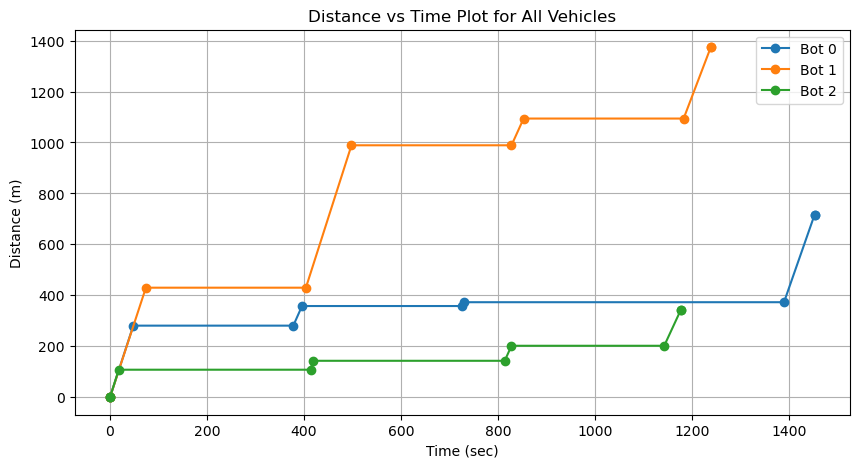

In [33]:
df['departure'] = df['arrival'] + df['service']

# Create a new dataframe with 'dist' and 'time' from each vehicle's data
time_data = []
for vehicle_id, vehicle_df in df.groupby('vehicle'):
    for _, row in vehicle_df.iterrows():
        time_data.append({'vehicle_id': vehicle_id, 'dist': row['distance'], 'time': row['arrival']})
        time_data.append({'vehicle_id': vehicle_id, 'dist': row['distance'], 'time': row['departure']})

# Creating the DataFrame for distance and time
time_df = pd.DataFrame(time_data)

# Create line plot for the time dataframe
plt.figure(figsize=(10, 5))

for vehicle_id, vehicle_data in time_df.groupby('vehicle_id'):
    plt.plot(vehicle_data['time'], vehicle_data['dist'], label=f'Bot {vehicle_id}', marker='o', linestyle='-')

plt.xlabel('Time (sec)')
plt.ylabel('Distance (m)')
plt.title('Distance vs Time Plot for All Vehicles')
plt.grid(True)
plt.legend()
plt.show()


### Charts: Number of Jobs per bot, and Distance travelled by each bot

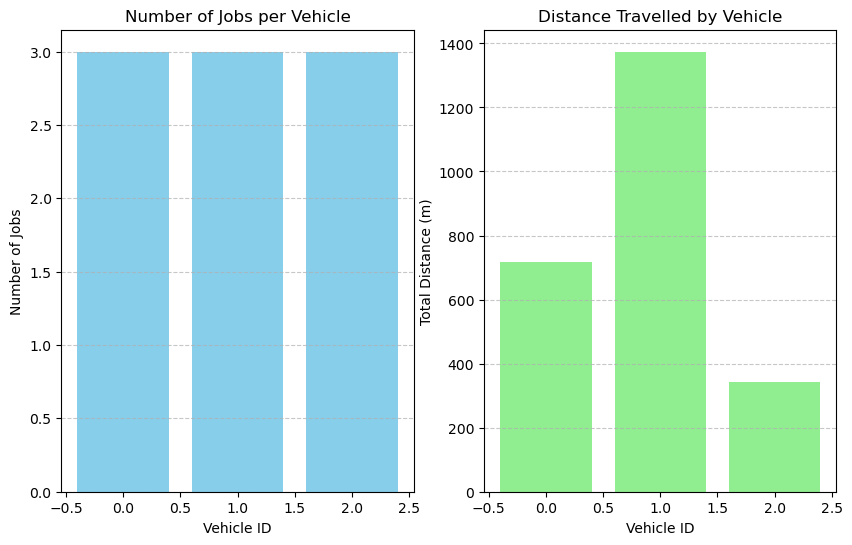

In [34]:
grouped_data = df.groupby('vehicle').agg({'job': 'count', 'distance': 'max'})

# Plotting the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=False)

# Number of jobs per vehicle
ax1.bar(grouped_data.index, grouped_data['job'], color='skyblue')
ax1.set_ylabel('Number of Jobs')
ax1.set_xlabel('Vehicle ID')
ax1.set_title('Number of Jobs per Vehicle')

# Total distance travelled per vehicle
ax2.bar(grouped_data.index, grouped_data['distance'], color='lightgreen')
ax2.set_ylabel('Total Distance (m)')
ax2.set_xlabel('Vehicle ID')
ax2.set_title('Distance Travelled by Vehicle')

# Adding gridlines
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Chart: Repair material deployed per bot.

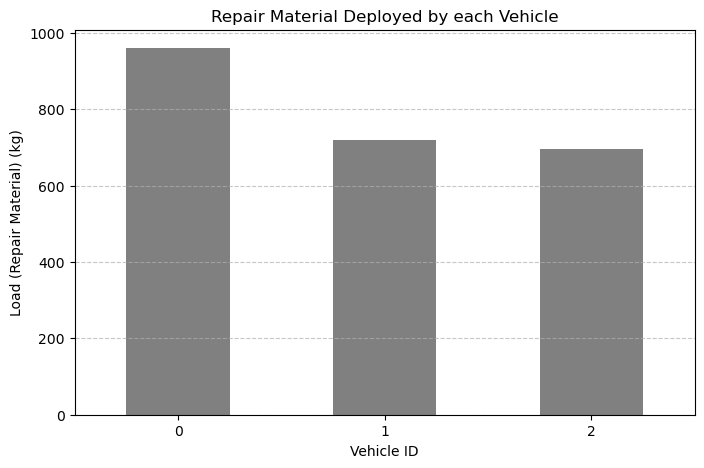

In [35]:
# Extracting load values as integers
df2 = df.copy()
df2['load'] = df2['load'].apply(lambda x: x[0])

load_df = df2[df2['step'] == 'start'].groupby('vehicle')['load'].sum()

plt.figure(figsize=(8, 5))
load_df.plot(kind='bar', color='grey')
plt.title('Repair Material Deployed by each Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Load (Repair Material) (kg)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Chart: Payload vs Time per bot.

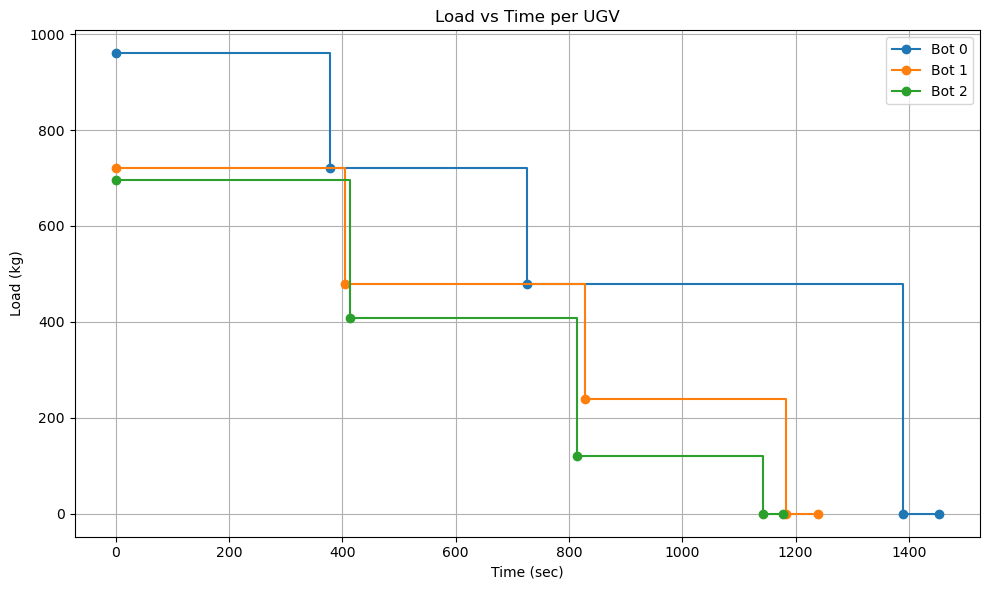

In [36]:
# Load vs time for each UGV
plt.figure(figsize=(10, 6))

# Iterate over each vehicle
for vehicle_id, data in df.groupby('vehicle'):
    # Sorting the data by duration (to ensure the line plot connects the points in right order)
    data = data.sort_values(by='duration')
    # Extracting the load values from the list
    load_values = [load[0] for load in data['load']]
    # Plotting load vs time for the current vehicle as a step line chart
    plt.step(data['departure'], load_values, where = "post", marker='o', linestyle='-', label=f'Bot {vehicle_id}')


# labels and title
plt.xlabel('Time (sec)')
plt.ylabel('Load (kg)')
plt.title('Load vs Time per UGV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Fault Tolerance

In [37]:
import numpy as np

def handle_failure(t: int, bot_id: int):
    offset_time=0
    incomplete_jobs = []
    for route_plan in route_plans:
        for route in route_plan['routes']:
            if route['vehicle']==bot_id:
                for step in route['steps']:
                    if step['arrival']>t and step.get('job', None) is not None:
                        incomplete_jobs.append(step['job'])
            else:
                for step in route['steps']:
                    offset_time = max(offset_time, step['arrival'])

    print('incomplete_jobs', incomplete_jobs) # prints pending jobs
    pending_jobs = []
    for j in jobs:
        if j.id in incomplete_jobs:
            pending_jobs.append(j)
    print(pending_jobs)
    
    fleet.bots.pop()
    return plan_the_routes(pending_jobs, fleet.bots, offset_time)

### Re-plan for remaining bots for pending jobs after 
bot (id=1) dies at time t=500

In [38]:
new_plans = handle_failure(t=500, bot_id=1)
new_plans

incomplete_jobs [300]


[{'code': 0,
  'summary': {'cost': 112,
   'routes': 1,
   'unassigned': 0,
   'delivery': [240],
   'amount': [240],
   'pickup': [0],
   'setup': 0,
   'service': 330,
   'duration': 112,
   'waiting_time': 0,
   'priority': 0,
   'distance': 560,
   'violations': [],
   'computing_times': {'loading': 49, 'solving': 0, 'routing': 14}},
  'unassigned': [],
  'routes': [{'vehicle': 0,
    'cost': 112,
    'delivery': [240],
    'amount': [240],
    'pickup': [0],
    'setup': 0,
    'service': 330,
    'duration': 112,
    'waiting_time': 0,
    'priority': 0,
    'distance': 560,
    'steps': [{'type': 'start',
      'location': [-1.517644, 53.789386],
      'setup': 0,
      'service': 0,
      'waiting_time': 0,
      'load': [240],
      'arrival': 1453,
      'duration': 0,
      'violations': [],
      'distance': 0},
     {'type': 'job',
      'location': [-1.516536749999375, 53.78941719738333],
      'id': 300,
      'setup': 0,
      'service': 330,
      'waiting_time': 0,
  

In [40]:
# Define an empty list to store route data
new_route_data = []

# Loop through each route in the 'routes' list
trip_num = 0
for route_plan in new_plans:
    trip_num += 1
    for route in route_plan['routes']:
        vehicle_num = route['vehicle']  # Get vehicle number

        # Loop through each step (job) within the route
        for step in route['steps']:
            # Extract relevant data from each step
            step_data = {
                'trip': trip_num,
                'vehicle': vehicle_num,
                'step': step['type'],
                'location': step['location'],
                'setup': step['setup'],
                'service': step['service'],
                'waiting_time': step['waiting_time'],
                'load': step['load'],
                'arrival': step['arrival'],
                'duration': step['duration'],
                'violations': step['violations'],
                'distance': step['distance'],
                'id': step.get('id', None),
                'job': step.get('job', None)
            }

            # Append the data for this step to the route_data list
            new_route_data.append(step_data)

# Create DataFrame from the route_data list
new_df = pd.DataFrame(new_route_data)

# Print the DataFrame
new_df

,trip,vehicle,step,location,setup,service,waiting_time,load,arrival,duration,violations,distance,id,job
0,1,0,start,"[-1.517644, 53.789386]",0,0,0,[240],1453,0,[],0,NaN,NaN
1,1,0,job,"[-1.516536749999375, 53.78941719738333]",0,330,0,[0],1509,56,[],280,300.0,300.0
2,1,0,end,"[-1.517644, 53.789386]",0,0,0,[0],1895,112,[],560,NaN,NaN


### Flatten JSON to convert into a DF

In [41]:
# Define an empty list to store route data
new_route_data = []

# Loop through each route in the 'routes' list
trip_num = 0
for route_plan in new_plans:
    trip_num += 1
    for route in route_plan['routes']:
        vehicle_num = route['vehicle']  # Get vehicle number

        # Loop through each step (job) within the route
        for step in route['steps']:
            # Extract relevant data from each step
            step_data = {
                'trip': trip_num,
                'vehicle': vehicle_num,
                'type': step['type'],
                'location': step['location'],
                'setup': step['setup'],
                'service': step['service'],
                'waiting_time': step['waiting_time'],
                'load': step['load'],
                'arrival': step['arrival'],
                'duration': step['duration'],
                'violations': step['violations'],
                'distance': step['distance'],
                'id': step.get('id', None),
                'job': step.get('job', None)
            }

            # Append the data for this step to the route_data list
            new_route_data.append(step_data)

# Create DataFrame from the route_data list
new_df = pd.DataFrame(new_route_data)

# Print the DataFrame
new_df

,trip,vehicle,type,location,setup,service,waiting_time,load,arrival,duration,violations,distance,id,job
0,1,0,start,"[-1.517644, 53.789386]",0,0,0,[240],1453,0,[],0,NaN,NaN
1,1,0,job,"[-1.516536749999375, 53.78941719738333]",0,330,0,[0],1509,56,[],280,300.0,300.0
2,1,0,end,"[-1.517644, 53.789386]",0,0,0,[0],1895,112,[],560,NaN,NaN
